<a href="https://colab.research.google.com/github/svenschultze/Lidar-Localization-DL/blob/main/notebooks/pgm_map_to_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from joblib import Parallel, delayed
from tqdm import tqdm

def read_pgm(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

# Load GMapping map

In [2]:
!wget -q https://huggingface.co/datasets/svenschultze/lidar-localization/resolve/main/map.pgm

In [3]:
map = read_pgm("map.pgm")
map = cv2.rotate(map, cv2.ROTATE_90_COUNTERCLOCKWISE)[30:335, 70:295]

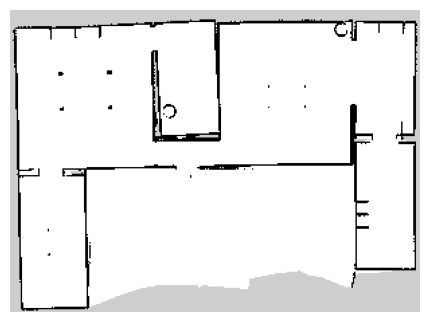

In [4]:
plt.figure(dpi=100)
plt.axis("off")
plt.imshow(map.transpose(), cmap="gray")

# Ray Marching Algorithm
Our approach is able to estimate the position of a robot in a two-dimensional space based on two-dimensional distance values obtained via LiDAR. When training the neural network, the presence of matching ground truths in the form of absolute coordinates is crucial. However, in the real world, this is generally not the case. To solve this problem, we used the SLAM implementation of GMapping in ROS to generate a map. Then, we applied a ray marching dataset generation algorithm to generate LiDAR-coordinate pairs:

![gmapping_dataset_generation.gif](https://github.com/svenschultze/Lidar-Localization-DL/blob/main/images/gmapping_dataset_generation.png?raw=true)

In [5]:
relevant_pixels = map == 254

coords = relevant_pixels.nonzero()
coords = list(zip(*coords))

In [6]:
c = random.choice(coords)

In [7]:
MAX_RANGE = 200 # @param

In [8]:
def pixel_path(angle):
    img = np.zeros((MAX_RANGE * 2 - 1, MAX_RANGE * 2 - 1))
    angle = np.radians(angle % 360)

    origin = (MAX_RANGE, MAX_RANGE)

    dx = int(round(MAX_RANGE * np.cos(angle))) + origin[0]
    dy = int(round(MAX_RANGE * np.sin(angle))) + origin[1]
    destination = (dx, dy)

    img = cv2.line(img, origin, destination, (1), 1)
    path = np.transpose(img.nonzero())

    path = np.array(sorted(path, key=lambda destination: np.linalg.norm(np.array(origin) - np.array(destination))))
    return path - MAX_RANGE

In [9]:
PIXEL_PATHS = [pixel_path(angle) for angle in range(360)]

In [10]:
def scan_direction(origin, angle):
    path = PIXEL_PATHS[angle]

    try: 
        for x, y in path + origin:
            if map[x, y] == 0:
                return min(np.linalg.norm(origin - np.array((x, y))) / MAX_RANGE, 1)
    except:
        return 1

    return 1

In [11]:
def scan(origin):
    return np.array([scan_direction(origin, angle) for angle in range(360)])

In [12]:
s = scan(c)

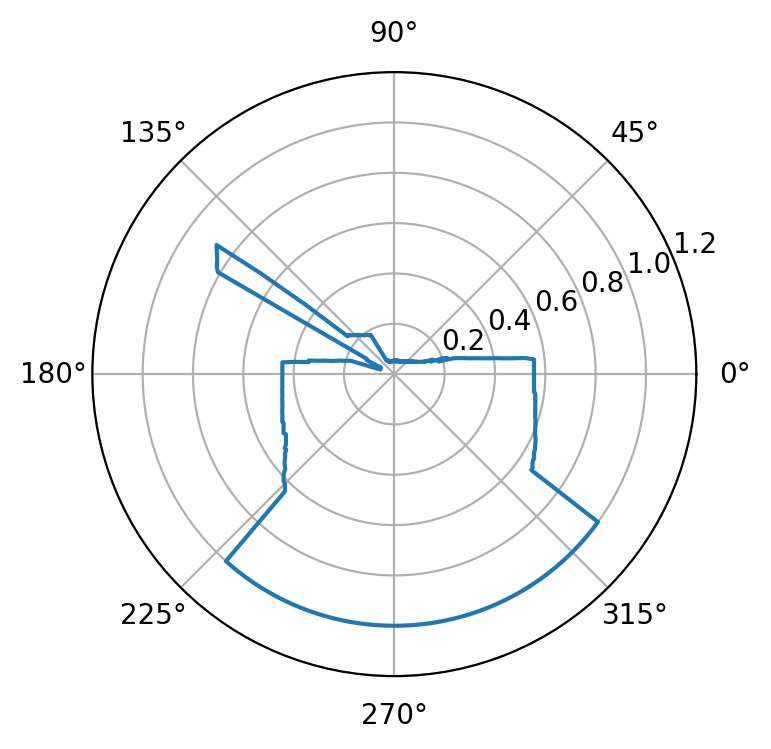

In [13]:
thetas = np.flip(np.arange(0, 360, 360 / len(s)))
plt.figure(dpi=200)
ax = plt.subplot(111, polar=True, projection='polar')
ax.set_ylim(0, 1.2)
ax.plot(np.radians(thetas), np.roll(np.flip(s), 90))

# Generate Dataset

In [14]:
X = Parallel(n_jobs=-1)(delayed(scan)(c) for c in tqdm(coords))

100%|██████████| 54938/54938 [1:05:32<00:00, 13.97it/s]


In [15]:
np.save("datasetX.npy", np.array(X))
np.save("datasetY.npy", np.array(coords))